# Import Libraries

In [1]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install -q torch-geometric

     |████████████████████████████████| 7.9 MB 2.8 MB/s 
     |████████████████████████████████| 3.5 MB 2.8 MB/s 
     |████████████████████████████████| 325 kB 5.2 MB/s 
     |████████████████████████████████| 407 kB 39.8 MB/s 
     |████████████████████████████████| 45 kB 2.7 MB/s 


In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)

import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score as nmi, adjusted_rand_score as ari
from sklearn.cluster import KMeans
import random
import warnings
warnings.filterwarnings('ignore')

import tqdm
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid, Reddit, Yelp
from torch_geometric.data import Data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

1.10.0+cu111
11.1
cpu


# SKFR1

In [3]:
# implementing z score to normalize each feature using mean and std via torch
def zscore(x):
    '''
    zscore normalization
    '''
    # get mean and std of each feature
    mean = torch.mean(x)
    std = torch.std(x)
    # if std is not 0, then normalize each feature
    if std != 0:
        x = (x - mean) / std
    else:
        x = x - mean
    return x



In [40]:
# PyTorch Implementation of the SKFR1 algorithm
# Input: data of shape (features, samples), clusters, k (number of clusters), sparsity
# Output: center of shape (features, clusters), clusters, list_loss
def skfr1(data, clusters, k, sparsity, maxiter):
    '''
    SKFR1 algorithm
    '''
    # get number of features and samples
    features, samples = data.shape
    # criteria of shape (features)
    criteria = torch.zeros(features).to(device)

    # normalize each feature
    for i in range(features):
        data[i, :] = zscore(data[i, :])
    
    # list_loss empty list
    list_loss = []
    # number of iterations
    num_iter = 1
    switched = True

    while switched and num_iter < maxiter:
        # initialize clusters
        center = torch.zeros((features, k)).to(device)
        # members of size clusters
        members = torch.zeros(k).to(device)
        # for each sample
        for j in range(samples):
            # i as jth cluster 
            i = clusters[j]
            # add sample to center
            center[:, i] = center[:, i] + data[:, j]
            # add 1 to members
            members[i] = members[i] + 1
        # for each cluster
        for j in range(k):
            # if members is not zero
            if members[j] != 0:
                # divide by members
                center[:, j] = center[:, j] / members[j]
        # update criteria d_l
        criteria = torch.matmul(torch.mul(center, center), members.T)
        # get index from criteria
        index = torch.LongTensor([i for i in range(len(criteria))]).to(device)
        # sort criteria
        sorted_criteria = sorted(zip(criteria, index))
        J = [x[1] for x in sorted_criteria]
        # make long tensor of J
        J = torch.LongTensor(J).to(device)
        # get only features-sparsity features of J
        J = J[:features-sparsity]
        # for each J feature index
        for i in range(len(J)):
            center[J[i]] = torch.zeros(k).to(device)
        # deleter members, criteria, index, sorted_criteria, J
        del members, criteria, index, sorted_criteria, J

        # get distamce as square root of sum of square of each feature 
        distance = torch.sqrt(((data.T - center.T[:, np.newaxis])**2).sum(axis=2))
        switched = False
        # for each sample
        for i in range(samples):
            # get index of minimum distance
            j = torch.argmin(distance[:, i])
            # if this index is not same as cluster
            if j != clusters[i]:
                # update cluster
                switched = True
                clusters[i] = j
                
        # deleter distance
        del distance
        # WSS as sum of square of each feature. Initialize to zero
        WSS = torch.zeros(k).to(device)
        # for each cluster
        for cluster in range(k):
            # get temporary index where cluster is k
            temp_index = torch.LongTensor(np.where(clusters.cpu().numpy() == cluster)[0]).to(device)
            # tempX as zero tensor of shape (features, len(temp_index))
            tempX = torch.zeros(features, len(temp_index)).to(device)
            # for each temp_index
            for j in range(len(temp_index)):
                # add data to tempX
                tempX[:, j] = data[:, temp_index[j]]
            # get WSS
            WSS[cluster] = torch.mean(((tempX.T - center[:, cluster]).T)**2)
        # get loss as sum of WSS
        loss = torch.sum(WSS)
        # add loss to list_loss
        list_loss.append(loss)
        # print iteration number and loss
        print('Iteration: {} Loss: {}'.format(num_iter, loss))
        # deleter tempX, temp_index, WSS, loss
        del tempX, temp_index, WSS, loss
        # update iteration number
        num_iter += 1
    return center, clusters, list_loss


## Plotting functions

In [41]:
def plot_data(X):
    plt.scatter(
    X[:, 0], X[:, 1],
    c='white', marker='o',
    edgecolor='black', s=50
    )
    plt.show()

def plot_clusters(X,centroids,cluster):
    sns.scatterplot(X[:,0], X[:, 1], hue=cluster)
    sns.scatterplot(centroids[:,0], centroids[:, 1], s=100, color='y')
    plt.xlabel('feature1')
    plt.ylabel('feature2')
    plt.show()

def plot_loss(loss_list):
    epochs = [i for i in range(len(loss_list))]
    plt.plot(epochs,loss_list)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

## Testing on Randomly Generated Data


Iteration: 1 Loss: 2.8858067989349365
Iteration: 2 Loss: 1.582001805305481
Iteration: 3 Loss: 1.236306071281433
Iteration: 4 Loss: 0.5662718415260315
Iteration: 5 Loss: 0.3996138870716095
Iteration: 6 Loss: 0.39602142572402954
Iteration: 7 Loss: 0.3957017660140991
Iteration: 8 Loss: 0.39569634199142456


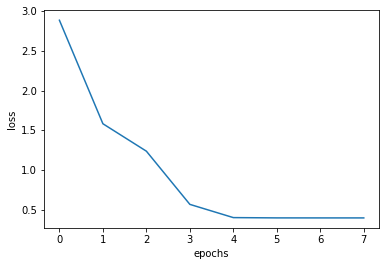

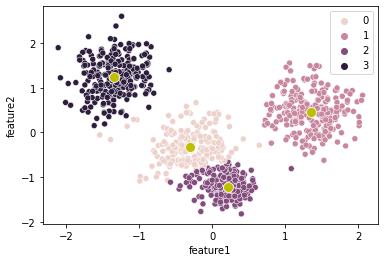

In [42]:
features = 2
cases = 1000
k = 4
sparsity = 2
X_random = np.random.normal(0,1,size=(features,cases//k))
j = 4
p = 1
for i in range(k-1):
    tmp = np.random.normal(j,2,size=(features,cases//k))
    if i%2==0:
        tmp[0] = -1*tmp[0]
    j+=4
    X_random = np.concatenate((X_random,tmp),axis=1)

X_random = torch.FloatTensor(X_random)
X_random = X_random.to(device)

Class = np.array(random.choices([i for i in range(k)],k=cases))
Class = torch.LongTensor(Class.tolist()).to(device)

centroids, cluster, loss_list = skfr1(X_random,Class,k,sparsity, 20)

plot_loss(loss_list)
plot_clusters(X_random.T.cpu(),centroids.T.cpu(),cluster.cpu())

# SKFR2

In [43]:
# PyTorch Implementation of the SKFR2 algorithm
# Input: data of shape (features, samples), clusters, k (number of clusters), sparsity
# Output: center of shape (features, clusters), clusters, list_loss
def skfr2(data, clusters, k, sparsity, maxiter):
    '''
    SKFR2 algorithm
    '''
    # get number of features and samples
    features, samples = data.shape
    # criteria of shape (features)
    criteria = torch.zeros(features).to(device)

    # normalize each feature
    for i in range(features):
        data[i, :] = zscore(data[i, :])
    
    # list_loss empty list
    list_loss = []
    # number of iterations
    num_iter = 1
    switched = True

    while switched and num_iter < maxiter:
        # initialize clusters
        center = torch.zeros(features, k).to(device)
        # members of size clusters
        members = torch.zeros(k).to(device)
        # for each sample
        for j in range(samples):
            # i as jth cluster 
            i = clusters[j]
            # add sample to center
            center[:, i] = center[:, i] + data[:, j]
            # add 1 to members
            members[i] = members[i] + 1
        # for each cluster
        for j in range(k):
            # if members is not zero
            if members[j] > 0:
                # divide by members
                center[:, j] = center[:, j] / members[j]
                # Get criteria = number of members in cluster multiplied by center*center
                criteria = members[j] * torch.mul(center[:, j], center[:, j])
                # get index from criteria
                index = torch.LongTensor([i for i in range(len(criteria))]).to(device)
                # sort criteria
                sorted_criteria = sorted(zip(criteria, index))
                J = [x[1] for x in sorted_criteria]
                # make long tensor of J
                J = torch.LongTensor(J).to(device)
                # get only features-sparsity features of J
                J = J[:features-sparsity]
                for i in range(len(J)):
                    center[J[i], j] = 0
        # deleter members, criteria, index, sorted_criteria, J
        del members, criteria, index, sorted_criteria, J

        # get distamce as square root of sum of square of each feature 
        distance = torch.sqrt(((data.T - center.T[:, np.newaxis])**2).sum(axis=2))
        switched = False
        # for each sample
        for i in range(samples):
            # get index of minimum distance
            j = torch.argmin(distance[:, i])
            # if this index is not same as cluster
            if j != clusters[i]:
                # update cluster
                switched = True
                clusters[i] = j

        # deleter distance
        del distance
        # WSS as sum of square of each feature. Initialize to zero
        WSS = torch.zeros(k).to(device)
        # for each cluster
        for cluster in range(k):
            # get temporary index where cluster is k
            temp_index = torch.LongTensor(np.where(clusters.cpu().numpy() == cluster)[0]).to(device)
            # tempX as zero tensor of shape (features, len(temp_index))
            tempX = torch.zeros(features, len(temp_index)).to(device)
            # for each temp_index
            for j in range(len(temp_index)):
                # add data to tempX
                tempX[:, j] = data[:, temp_index[j]]
            # get WSS
            WSS[cluster] = torch.mean(((tempX.T - center[:, cluster]).T)**2)
        # get loss as sum of WSS
        loss = torch.sum(WSS)
        # add loss to list_loss
        list_loss.append(loss)
        # print iteration number and loss
        print('Iteration: {} Loss: {}'.format(num_iter, loss))
        # deleter tempX, temp_index, WSS, loss
        del tempX, temp_index, WSS, loss
        # update iteration number
        num_iter += 1
    return center, clusters, list_loss









Iteration: 1 Loss: 3.936830997467041
Iteration: 2 Loss: 0.5695741176605225
Iteration: 3 Loss: 0.5084350109100342
Iteration: 4 Loss: 0.49465250968933105
Iteration: 5 Loss: 0.48628509044647217
Iteration: 6 Loss: 0.4885415732860565
Iteration: 7 Loss: 0.487775981426239
Iteration: 8 Loss: 0.4872906506061554
Iteration: 9 Loss: 0.4868339002132416
Iteration: 10 Loss: 0.4859066903591156
Iteration: 11 Loss: 0.4858342111110687


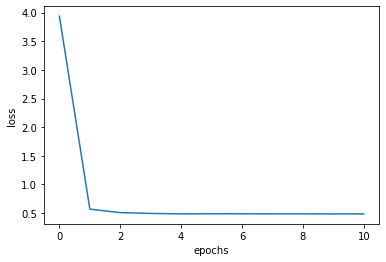

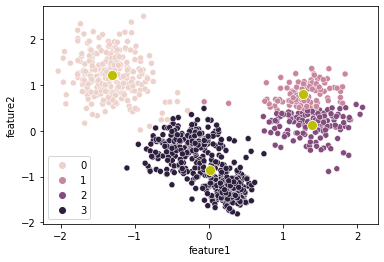

In [44]:
features = 2
cases = 1000
k = 4
sparsity = 2
X_random = np.random.normal(0,1,size=(features,cases//k))
j = 4
p = 1
for i in range(k-1):
    tmp = np.random.normal(j,2,size=(features,cases//k))
    if i%2==0:
        tmp[0] = -1*tmp[0]
    j+=4
    X_random = np.concatenate((X_random,tmp),axis=1)

X_random = torch.FloatTensor(X_random)
X_random = X_random.to(device)

Class = np.array(random.choices([i for i in range(k)],k=cases))
Class = torch.LongTensor(Class.tolist()).to(device)

centroids, cluster, loss_list = skfr2(X_random,Class,k,sparsity, 20)

plot_loss(loss_list)
plot_clusters(X_random.T.cpu(),centroids.T.cpu(),cluster.cpu())